<span style="font-size:3em;">Ch4: Real-world data
 representation
 using tensors</span>
 
 Each section in this chapter will describe a data type, and each will come with its
own dataset. We’ll be using a lot of image and volumetric data through the rest of the book,
since those are common data types and they reproduce well in book format. We’ll also
cover tabular data, time series, and text, as those will also be of interest to a number of
our readers. 

In every section, we will stop where a deep learning researcher would start: right
before feeding the data to a model.


In [4]:
import torch

# 4.1 Working with Images

## 4.1.1Images as an array
 An image is represented as a collection of scalars arranged in a regular grid with a
height and a width (in pixels). We might have a single scalar per grid point (the
pixel), which would be represented as a grayscale image; or multiple scalars per grid
point, which would typically represent different colors, as we saw in the previous chapter, or different features like depth from a depth camera.

Scalars representing values at individual pixels are often encoded using 8-bit integers, as in consumer cameras. In medical, scientific, and industrial applications, it is
not unusual to find higher numerical precision, such as 12-bit or 16-bit. This allows a
wider range or increased sensitivity in cases where the pixel encodes information
about a physical property, like bone density, temperature, or depth.

## 4.1.2 Loading an Image file
Images come in several different file formats, but luckily there are plenty of ways to
load images in Python. Let’s start by loading a PNG image using the <b>imageio</b> module

<b>NOTE:</b> We’ll use imageio throughout the chapter because it handles different
data types with a uniform API. For many purposes, using TorchVision is a
great default choice to deal with image and video data. We go with imageio
here for somewhat lighter exploration.

In [1]:
import imageio

In [2]:
img_arr = imageio.imread('../dlwpt-code/data/p1ch4/image-dog/bobby.jpg')
img_arr.shape

(720, 1280, 3)

At this point, img is a NumPy array-like object with three dimensions: two spatial
dimensions, width and height; and a third dimension corresponding to the red,
green, and blue channels. Any library that outputs a NumPy array will suffice to obtain
a PyTorch tensor. 

## 4.1.3 Changing the Layout

The only thing to watch out for is the layout of the dimensions.
PyTorch modules dealing with image data require tensors to be laid out as <b>C × H × W </b>:
channels, height, and width, respectively. (TensorFlow is H x W C but it doesnt make a huge difference, need to just make sure we change the layout accordingly)


We can use the tensor’s permute method with the old dimensions for each new dimension to get to an appropriate layout. Given an input tensor H × W × C as obtained previously, we get a proper layout by having channel 2 first and then channels 0 and 1:

Changing the layout using <b> permute</b> does not make a copy and instead uses the same storage and only changes size and stride. This means this operation is extremely cheap.


In [5]:
img = torch.from_numpy(img_arr)
out = img.permute(2,0,1)

#Note: Changing a pixel in img will change out since its not a copy but a new view

To create a dataset of multiple images to use as an input for our
neural networks, we store the images in a batch along the first dimension to obtain an
N × C × H × W tensor. An slightly more efficient alternative to using "stack" is to <b>preallocate a tensor of the appropriate size and shape and fill it with images loaded from the directory</b>

In [6]:
batch_size = 3
batch = torch.zeros(batch_size, 3, 256, 256, dtype=torch.uint8)

#We can now load all PNG images from an input directory and store them in the tensor:
import os

data_dir = '../dlwpt-code/data/p1ch4/image-cats/'
filenames = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.png']

for i, filename in enumerate(filenames):
    img_arr = imageio.imread(os.path.join(data_dir, filename))
    img_t = torch.from_numpy(img_arr)
    img_t = img_t.permute(2,0,1)
    img_t = img_t[:3]
    batch[i] = img_t

## 4.1.4 Normalizing the Data
Neural networks exhibit the best training performance when the input
data ranges roughly from 0 to 1, or from -1 to 1 (this is an effect of how their building
blocks are defined).
 So a typical thing we’ll want to do is cast a tensor to floating-point and normalize
the values of the pixels. Casting to floating-point is easy, but normalization is trickier,
as it depends on what range of the input we decide should lie between 0 and 1 (or -1
and 1).

In [14]:
batch = batch.float()
batch /= 255.0

n_channels = batch.shape[1]
for c in range(n_channels):
    mean = torch.mean(batch[:,c])
    std = torch.std(batch[:,c])
    batch[:,c] = (batch[:,c] - mean) / std

<b>NOTE</b> Here, we normalize just a single batch of images because we do not
know yet how to operate on an entire dataset. In working with images, it is good
practice to compute the mean and standard deviation on all the training data
in advance and then subtract and divide by these fixed, precomputed quantities.

We can perform several other operations on inputs, such as geometric transformations like rotations, scaling, and cropping. These may help with training or may be
required to make an arbitrary input conform to the input requirements of a network,
like the size of the image.

# 4.2 3D Images: Volumetric Data

 In CT scans, the intensity represents the density of the different parts of the body—lungs, fat, water, muscle,
and bone, in order of increasing density—mapped from dark to bright when the CT
scan is displayed on a clinical workstation. The density at each point is computed from
the amount of X-rays reaching a detector after crossing through the body, with some
complex math to deconvolve the raw sensor data into the full volume.
 
 
 CTs have only a single intensity channel, similar to a grayscale image. This means
that often, the channel dimension is left out in native data formats; so, similar to the
last section, the raw data typically has three dimensions. By stacking individual 2D
slices into a 3D tensor, we can build volumetric data representing the 3D anatomy of a
subject. Unlike what we saw in figure 4.1, the extra dimension in figure 4.2 represents
an offset in physical space, rather than a particular band of the visible spectrum.


Part 2 of this book will be devoted to tackling a medical imaging problem in the real
world, so we won’t go into the details of medical-imaging data formats. For now, it suffices to say that there’s no fundamental difference between a tensor storing volumetric data versus image data. <b>We just have an extra dimension, depth, after the channel
dimension, leading to a 5D tensor of shape N × C × D × H × W</b>



We can load the volumetric data using the <b>volread</b> function in the imageio modeule which takes a directory as an argument and assembles  all Digital Imaging and Communications in Medicine (DICOM) files2
 in a series in a NumPy 3D array 

In [15]:
dir_path = '../dlwpt-code/data/p1ch4/volumetric-dicom/2-LUNG 3.0  B70f-04083/'
vol_arr = imageio.volread(dir_path, 'DICOM')
vol_arr.shape

Reading DICOM (examining files): 1/99 files (1.0%61/99 files (61.6%99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 17/99  (17.258/99  (58.699/99  (100.0%99/99  (100.0%)


(99, 512, 512)

As was true in section 4.1, the layout is different from what PyTorch expects, due to
having no channel information. So we’ll have to make room for the channel dimension using unsqueeze:

In [20]:
vol = torch.from_numpy(vol_arr).float()
vol = torch.unsqueeze(vol,0)

vol.shape

#At this point we could assemble a 5D dataset by stacking multiple volumes along the batch direction

torch.Size([1, 99, 512, 512])

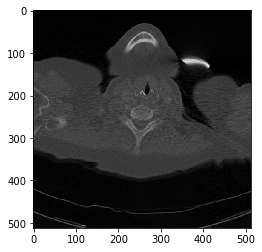

In [25]:
#here is one of the slices of depth
import matplotlib.pyplot as plt
%matplotlib inline

im = vol[0,0,:,:]
im.shape


plt.imshow(im,cmap='gray')

# 4.3 Representing Tabular Data

The simplest form of data we’ll encounter on a machine learning job is sitting in a
spreadsheet, CSV file, or database. Whatever the medium, it’s a table containing one
row per sample (or record), where columns contain one piece of information about our sample.


Tabular data is typically not homogeneous: different columns don’t have the same type. PyTorch tensors, on the other hand, are homogeneous. Information in PyTorch is
typically encoded as a number, typically floating-point (though integer types and
Boolean are supported as well). This numeric encoding is deliberate, since neural
networks are mathematical entities that take real numbers as inputs and produce real
numbers as output through successive application of matrix multiplications and
nonlinear functions.

## 4.3.1 Using a real-world dataset

Our first job as deep learning practitioners is to encode heterogeneous, real-world
data into a tensor of floating-point numbers, ready for consumption by a neural network

Were going to use the Wine Quality Dataset.  The file contains a comma-separated collection of values organized in 12 columns
preceded by a header line containing the column names. The first 11 columns contain values of chemical variables, and the last column contains the sensory quality
score from 0 (very bad) to 10 (excellent).



## 4.3.2 Loading a wine data tensor
 Python offers several options for
quickly loading a CSV file. Three popular options are
- The csv module that ships with Python
- NumPy
- Pandas
    - Pandas is the most time- and memory-efficient.

In [28]:
import csv
import numpy as np

#skip first row since it has column names
wine_path = '../dlwpt-code/data/p1ch4/tabular-wine/winequality-white.csv'
wineq_numpy = np.loadtxt(wine_path, dtype= np.float32, delimiter=';', skiprows=1)
wineq_numpy

array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
       [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
       [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
       [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
       [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]], dtype=float32)

In [30]:
#lets check shape and columns
col_list = next(csv.reader(open(wine_path), delimiter= ';'))

wineq_numpy.shape, col_list

((4898, 12),
 ['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol',
  'quality'])

In [31]:
#convert NumPy array to Tensor
wineq = torch.from_numpy(wineq_numpy)
wineq.shape, wineq.dtype

(torch.Size([4898, 12]), torch.float32)

## 4.3.3 Representing scores

We will typically remove the score from the tensor of input data and keep it in a separate tensor, so that we can use the score as the ground truth without it being input to our model

In [44]:
data = wineq[:,:-1]
target = wineq[:,-1]
data.shape, target.shape

(torch.Size([4898, 11]), torch.Size([4898]))

## 4.3.4 One-hot encoding

We can achieve one-hot encoding using the <b>scatter_</b> method, which fills the tensor with values from a source tensor along the indices provided as arguments:

The arguments for scatter_ are as follows:
- The dimension along which the following two arguments are specified
- A column tensor indicating the indices of the elements to scatter
-  A tensor containing the elements to scatter or a single scalar to scatter (1, in
this case)


The call to unsqueeze adds a singleton dimension, from a 1D tensor of 4,898 elements
to a 2D tensor of size (4,898 × 1), without changing its contents—no extra elements
are added; we just decided to use an extra index to access the elements. That is, we
access the first element of target as target[0] and the first element of its
unsqueezed counterpart as target_unsqueezed[0,0].

In [49]:
target = wineq[:,-1].long() #target needs to be long datatype
target_onehot = torch.zeros(target.shape[0], 10).long()

#since target_onehot only has 2 dimensions, we need to add another w/ unsqueeze
print(target.unsqueeze(1))
target_onehot.scatter_(1, target.unsqueeze(1), 1.0)

tensor([[6],
        [6],
        [6],
        ...,
        [6],
        [7],
        [6]])


tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

## 4.3.5 When to categorize

You may
wonder what the deal is with the ordinal case discussed in the earlier sidebar. There is
no general recipe for it; most commonly, such data is either treated as categorical (losing the ordering part, and hoping that maybe our model will pick it up during training if we only have a few categories) or continuous (introducing an arbitrary notion of distance).

## 4.3.6 Finding thresholds

Next, let’s start to look at the data with an eye to seeing if there is an easy way to tell
good and bad wines apart at a glance. First, we’re going to determine which rows in
target correspond to a score less than or equal to 3

Note that only 20 of the bad_indexes entries are set to True! By using a feature in
PyTorch called advanced indexing, we can use a tensor with data type torch.bool to
index the data tensor. This will essentially filter data to be only items (or rows) corresponding to True in the indexing tensor. The bad_indexes tensor has the same shape
as target, with values of False or True depending on the outcome of the comparison
between our threshold and each element in the original target tensor:

<b> Note:</b> This is exactly like Pandas indexing

In [54]:
bad_indexes = target <= 3
bad_indexes.shape, bad_indexes.dtype, bad_indexes.sum()

(torch.Size([4898]), torch.bool, tensor(20))

In [55]:
bad_data = data[bad_indexes]
bad_data.shape

torch.Size([20, 11])

In [57]:
# Now we can start to get info about wines grouped into good, middle, and bad categories. 
#Take the .mean() of each col:
bad_data = data[target <= 3]
mid_data = data[(target > 3) & (target < 7)] #just like in Pandas use & for multiple conditions
good_data = data[target >= 7]

bad_mean = torch.mean(bad_data, dim=0)
mid_mean = torch.mean(mid_data, dim=0)
good_mean = torch.mean(good_data, dim=0)

for i, args in enumerate(zip(col_list, bad_mean, mid_mean, good_mean)):
    print('{:2} {:20} {:6.2f} {:6.2f} {:6.2f}'.format(i, *args))

 0 fixed acidity          7.60   6.89   6.73
 1 volatile acidity       0.33   0.28   0.27
 2 citric acid            0.34   0.34   0.33
 3 residual sugar         6.39   6.71   5.26
 4 chlorides              0.05   0.05   0.04
 5 free sulfur dioxide   53.33  35.42  34.55
 6 total sulfur dioxide 170.60 141.83 125.25
 7 density                0.99   0.99   0.99
 8 pH                     3.19   3.18   3.22
 9 sulphates              0.47   0.49   0.50
10 alcohol               10.34  10.26  11.42


At first glance, the bad wines seem to have higher total sulfur dioxide, among other differences. We could use a threshold on total sulfur dioxide as a crude criterion for discriminating good wines from bad ones.

In [58]:
total_sulfur_threshold = 141.83
total_sulfur_data = data[:,6]
predicted_indexes = torch.lt(total_sulfur_data, total_sulfur_threshold) #torch.lt computes less than(lt)

predicted_indexes.shape, predicted_indexes.dtype, predicted_indexes.sum()

(torch.Size([4898]), torch.bool, tensor(2727))

In [59]:
#Now we can check threshold of good wines and see if how accureate looking at sulfur is
actual_indexes = target > 5
actual_indexes.shape, actual_indexes.dtype, actual_indexes.sum()

(torch.Size([4898]), torch.bool, tensor(3258))

Since there are about 500 more actually good wines than our threshold predicted, we
already have hard evidence that it’s not perfect. Now we need to see how well our predictions line up with the actual rankings. 

We will perform a logical “and” between our
prediction indexes and the actual good indexes 

In [60]:
n_matches = torch.sum(actual_indexes & predicted_indexes).item()
n_predicted = torch.sum(predicted_indexes).item()
n_actual = torch.sum(actual_indexes).item()
n_matches, n_matches/n_predicted, n_matches/n_actual

(2018, 0.74000733406674, 0.6193984039287906)

We got around 2,000 wines right! Since we predicted 2,700 wines, this gives us a 74%
chance that if we predict a wine to be high quality, it actually is. Unfortunately, there
are 3,200 good wines, and we only identified 61% of them. 

# 4.4 Working with time series

In the previous section, we covered how to represent data organized in a flat table. As
we noted, every row in the table was independent from the others; their order did not
matter. 

we’ll switch to another
interesting dataset: data from a Washington, D.C., bike-sharing system reporting the
hourly count of rental bikes in 2011–2012 in the Capital Bikeshare system, along with
weather and seasonal information. <b> Our goal
will be to take a flat, 2D dataset and transform it into a 3D one</b>

## 4.4.1 Adding a time dimension
 We want to change the row-per-hour
organization so that we have one axis that increases at a rate of one day per index increment, and another axis that represents the hour of the day. The third axis will be our different columns of data.

In [61]:
bikes_numpy = np.loadtxt(
    '../dlwpt-code/data/p1ch4/bike-sharing-dataset/hour-fixed.csv',
    dtype = np.float32,
    delimiter=',',
    skiprows=1,
    converters = {1: lambda x: float(x[8:10])} #converts date string to #'s correspond to day of month'
    )

bikes = torch.from_numpy(bikes_numpy)
bikes

tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 3.0000e+00, 1.3000e+01,
         1.6000e+01],
        [2.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 8.0000e+00, 3.2000e+01,
         4.0000e+01],
        [3.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 5.0000e+00, 2.7000e+01,
         3.2000e+01],
        ...,
        [1.7377e+04, 3.1000e+01, 1.0000e+00,  ..., 7.0000e+00, 8.3000e+01,
         9.0000e+01],
        [1.7378e+04, 3.1000e+01, 1.0000e+00,  ..., 1.3000e+01, 4.8000e+01,
         6.1000e+01],
        [1.7379e+04, 3.1000e+01, 1.0000e+00,  ..., 1.2000e+01, 3.7000e+01,
         4.9000e+01]])

In [63]:
col_list = next(csv.reader(open('../dlwpt-code/data/p1ch4/bike-sharing-dataset/hour-fixed.csv'),delimiter=','))
col_list

['instant',
 'dteday',
 'season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 'cnt']

 For the time being, we’re going to focus on learning how to turn our
bike-sharing dataset into something that our neural network will be able to ingest in
fixed-size chunks.This neural network model will need to see a number of sequences of values for
each different quantity, such as ride count, time of day, temperature, and weather conditions:

<b>We end up with N parallel sequences of size C. </b>
- C stands for channel, in neural network parlance, and is the same as column for 1D data like we have here. 
- The N dimension represents the time axis, here one entry per hour.


## 4.4.2 Shaping the data by time period

We might want to break up the two-year dataset into wider observation periods, like
days. This way we’ll have N (for number of samples) collections of C sequences of length
L. <b>In other words, our time series dataset would be a tensor of dimension 3 and shape
N × C × L.</b> The C would remain our 17 channels, while L would be 24: 1 per hour of
the day. There’s no particular reason why we must use chunks of 24 hours, though the
general daily rhythm is likely to give us patterns we can exploit for predictions. We
could also use 7 × 24 = 168 hour blocks to chunk by week instead, if we desired. All of
this depends, naturally, on our dataset having the right size—the number of rows must
be a multiple of 24 or 168. Also, for this to make sense, we cannot have gaps in the
time series

First col is the index (the global ordering of the data), the second is the date, and the sixth is the time of day

If our dataset wasnt already sorted we could use torch.sort()

In [65]:
#to obtain daily hours, just view same tensor in batches of 24 hours
bikes.shape, bikes.stride()

(torch.Size([17520, 17]), (17, 1))

In [67]:
#That’s 17,520 hours, 17 columns. Now let’s reshape the data to have 3 axes—day, hour, and then our 17 columns:
daily_bikes = bikes.view(-1,24,bikes.shape[1])
daily_bikes.shape, daily_bikes.stride()

(torch.Size([730, 24, 17]), (408, 17, 1))

 calling <b>view</b> on a tensor returns a new tensor that changes the number of dimensions and the striding information, without
changing the storage. This means we can rearrange our tensor at basically zero cost,
because no data will be copied. Our call to view requires us to provide the new shape
for the returned tensor. <b>We use -1 as a placeholder for “however many indexes are
left, given the other dimensions and the original number of elements.”</b>

    
Remember also that storage is a contiguous, linear container for numbers (floating-point, in this case). Our bikes tensor will have each row
stored one after the other in its corresponding storage. This is confirmed by the output from the call to bikes.stride() earlier.
    
 For daily_bikes, the stride is telling us that advancing by 1 along the hour dimension (the second dimension) requires us to advance by 17 places in the storage (or
one set of columns); whereas advancing along the day dimension (the first dimension) requires us to advance by a number of elements equal to the length of a row in
the storage times 24 (here, 408, which is 17 × 24).

<b>In other words, we now have N sequences of L hours in a day, for C channels. To get to our desired N × C × L ordering, we need to transpose the tensor:</b>

In [68]:
daily_bikes = daily_bikes.transpose(1,2)
daily_bikes.shape, daily_bikes.stride()

(torch.Size([730, 17, 24]), (408, 1, 17))

## 4.4.3 Ready for training

"Weather Situation" variable is ordinal, could be treated as categorical or contiuous. If we got categorical we can OHE the variable. 

 In order to make it easier to render our data, we’re going to limit ourselves to the
first day for a moment. We initialize a zero-filled matrix with a number of rows equal
to the number of hours in the day and number of columns equal to the number of
weather levels:

In [71]:
first_day  = bikes[:24].long()
weather_onehot = torch.zeros(first_day.shape[0],4)
first_day[:,9]

tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2])

In [72]:
#Then scatter ones in our matrix. Remember to use unsqueeze to add a dimension
weather_onehot.scatter_(
            dim = 1,
            index=first_day[:,9].unsqueeze(1).long() - 1, #decrease values by 1 so values match intergets
            value=1.0)

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]])

In [77]:
#concatenate back to original dataset using "cat" along column dimension 1
torch.cat((bikes[:24], weather_onehot), 1)[:1]

tensor([[ 1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  6.0000,
          0.0000,  1.0000,  0.2400,  0.2879,  0.8100,  0.0000,  3.0000, 13.0000,
         16.0000,  1.0000,  0.0000,  0.0000,  0.0000]])

For cat to succeed, it is required that the tensors have the same size along the other dimensions—the row dimension, in this case

We could have done the same with the reshaped daily_bikes tensor. Remember
that it is shaped (B, C, L), where L = 24. We first create the zero tensor, with the same
B and L, but with the number of additional columns as C:

In [78]:
daily_weather_onehot = torch.zeros(daily_bikes.shape[0],
                                  4,
                                  daily_bikes.shape[2])
daily_weather_onehot.shape

torch.Size([730, 4, 24])

In [79]:
#Now scatter OHE into the tensor in the C dimension, performed in place so only content of this tensor will change
daily_weather_onehot.scatter_(
    1, daily_bikes[:,9,:].long().unsqueeze(1) - 1, 1.0)
daily_weather_onehot.shape

torch.Size([730, 4, 24])

In [83]:
#then concatenate
daily_bikes = torch.cat((daily_bikes, daily_weather_onehot), dim=1)
daily_bikes.shape

torch.Size([730, 21, 24])

We mentioned earlier that this is not the only way to treat our “weather situation” variable. Indeed, its labels have an ordinal relationship, so we could pretend they are special values of a continuous variable. We could just transform the variable so that it runs from 0.0 to 1.0:

In [86]:
daily_bikes[:,9,:] = (daily_bikes[:,9,:] - 1.0) / 3.0

torch.Size([730, 24])

There are multiple possibilities for rescaling variables. 

In [87]:
#can map range to (0,1), this is called MinMax Scaling
temp = daily_bikes[:,10,:]
temp_min = torch.min(temp)
temp_max = torch.max(temp)
daily_bikes[:,10,:] = ((daily_bikes[:,10,:] - temp_min)/ (temp_max - temp_min))

#or subtract the mean and divide by std
temp = daily_bikes[:, 10, :]
daily_bikes[:,10,:] = ((daily_bikes[:,10,:] - torch.mean(temp))/ torch.std(temp))

# 4.5 Representing text

 These models are called recurrent neural networks (RNNs), and they
have been applied with great success to text categorization, text generation, and automated translation systems. More recently, a class of networks called transformers with a more flexible way to incorporate past information has made a big splash. 

 Our goal in this section is to turn text into something a neural network can process: a tensor of numbers
 
## 4.5.1 Converting text to numbers

There are two particularly intuitive levels at which networks operate on text: at the
character level, by processing one character at a time, and at the word level, where
individual words are the finest-grained entities to be seen by the network. The technique with which we encode text information into tensor form is the same whether we
operate at the character level or the word level.

 Let’s start with a character-level example and use the dataset Project Gutenberg. The exact file is Jane Austens Price and Prejudice. 

In [98]:
with open('../dlwpt-code/data/p1ch4/jane-austen/1342-0.txt', encoding='utf8') as f:
    text = f.read()

## 4.5.2 One-hot-encoding characters

There’s one more detail we need to take care of before we proceed: encoding. This is
a pretty vast subject, and we will just touch on it. Every written character is represented
by a code: a sequence of bits of appropriate length so that each character can be
uniquely identified (Unicode is the standard encoding of strings in python since it replaced ASCII). 

It is instrumental to limit the one-hot
encoding to a character set that is useful for the text being analyzed. In our case, since
we loaded text in English, it is safe to use ASCII and deal with a small encoding. We
could also make all of the characters lowercase, to reduce the number of different
characters in our encoding. Similarly, we could screen out punctuation, numbers, or
other characters that aren’t relevant to our expected kinds of text. This may or may
not make a practical difference to a neural network, depending on the task at hand.

Each character will be represented by a vector of
length equal to the number of different characters in the encoding. This vector will
contain all zeros except a one at the index corresponding to the location of the character in the encoding

In [99]:
lines = text.split('\n')
line = lines[200]
print(line)

#now create a tensor that can hold total # of OHE variables
letter_t = torch.zeros(len(line),128) #128 is hard coded due to limits of ASCII
letter_t.shape

“Impossible, Mr. Bennet, impossible, when I am not acquainted with him


torch.Size([70, 128])

Note that letter_t holds a one-hot-encoded character per row. Now we just have to
set a one on each row in the correct position so that each row represents the correct
character. The index where the one has to be set corresponds to the index of the character in the encoding:

In [100]:
for i, letter in enumerate(line.lower().strip()):
    letter_index = ord(letter) if ord(letter) < 128 else 0 #text uses directional dble quotes which arnt ASCII valid
    letter_t[i][letter_index] = 1

## 4.5.3 One-hot encoding whole words
We have one-hot encoded our sentence into a representation that a neural network
could digest. Word-level encoding can be done the same way by establishing a vocabulary and one-hot encoding sentences—sequences of words—along the rows of our
tensor. Since a vocabulary has many words, this will produce very wide encoded vectors, which may not be practical. We will see in the next section that there is a more
efficient way to represent text at the word level, using embeddings. For now, let’s stick
with one-hot encodings and see what happens.

In [103]:
#first we need to clean the words
def clean_words(input_str):
    punctuation = '.,;:"!?”“_-'
    word_list = input_str.lower().replace('\n',' ').split()
    word_list = [word.strip(punctuation) for word in word_list]
    return word_list


words_in_line = clean_words(line)
line, words_in_line

('“Impossible, Mr. Bennet, impossible, when I am not acquainted with him',
 ['impossible',
  'mr',
  'bennet',
  'impossible',
  'when',
  'i',
  'am',
  'not',
  'acquainted',
  'with',
  'him'])

In [104]:
#now lets build a mapping of indexes to our encoding
word_list = sorted(set(clean_words(text)))

word2index_dict = {word: i for (i, word) in enumerate(word_list)}
len(word2index_dict), word2index_dict['impossible']

(7261, 3394)

In [105]:
#now we can use word2index_dict to efficiently find the index of a word as we OHE it
#we break up the senctence into words and one-hot encode it (i.e. we populate a tensor w/ 1 OHE vector of a word)

word_t = torch.zeros(len(words_in_line), len(word2index_dict))
for i, word in enumerate(words_in_line):
    word_index = word2index_dict[word]
    word_t[i][word_index] = 1
    print('{:2} {:4} {}'.format(i,word_index, word))

 0 3394 impossible
 1 4305 mr
 2  813 bennet
 3 3394 impossible
 4 7078 when
 5 3315 i
 6  415 am
 7 4436 not
 8  239 acquainted
 9 7148 with
10 3215 him


## 4.5.4 Text embeddings

As we have anticipated, one-hot encoding starts to break down when
the number of items to encode is effectively unbound, as with words in a corpus.

We certainly could do some work to deduplicate words, condense alternate spellings, collapse past and future tenses into a single token, and that kind of thing. Still, a
general-purpose English-language encoding would be huge. Even worse, every time we
encountered a new word, we would have to add a new column to the vector, which
would mean adding a new set of weights to the model to account for that new vocabulary entry—which would be painful from a training perspective.

 <b>How can we compress our encoding down to a more manageable size and put a
cap on the size growth? </b>

Well, instead of vectors of many zeros and a single one, we can use vectors of floating-point numbers. A vector of, say, 100 floating-point numbers can
indeed represent a large number of words. The trick is to find an effective way to map
individual words into this 100-dimensional space in a way that facilitates downstream
learning. This is called an <b>embedding</b>


In principle, we could simply iterate over our vocabulary and generate a set of 100
random floating-point numbers for each word. This would work, in that we could
cram a very large vocabulary into just 100 numbers, but it would forgo any concept of
distance between words based on meaning or context. A model using this word
embedding would have to deal with very little structure in its input vectors. An ideal
solution would be to generate the embedding in such a way that words used in similar
contexts mapped to nearby regions of the embedding.

 By processing a large corpus of organic text, embeddings similar to the one we just discussed
can be generated. The main differences are that there are 100 to 1,000 elements in
the embedding vector and that axes do not map directly to concepts: rather, conceptually similar words map in neighboring regions of an embedding space whose axes
are arbitrary floating-point dimensions.

<b>The embeddings are a parameter of a Neural Network that is learned during training</b>

## 4.5.5 Text embeddings as a blueprint

We believe that how text is represented and processed can also be seen as an example for
dealing with categorical data in general. Embeddings are useful wherever one-hot
encoding becomes cumbersome. Indeed, in the form described previously, they are
an efficient way of representing one-hot encoding immediately followed by multiplication with the matrix containing the embedding vectors as rows.